In [97]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
# import MagellanicStream as ms

## Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

###
import linearfitting as linfit
import geometry as geo

import mlefitting as mlefit
import olsfitting as olsfit
import utilities as util

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
#######################
### Import SMC Data ###
#######################

#total number 1225
smc = fits.getdata('/Users/joshpovick/Research/SMC_Gradients/smc_rgbmembers.r13-l33-58932beta.fits.gz') 

cln = np.where((smc['FE_H']>-9999.0)&(smc['AK_TARG']>-9999.0)&(smc['LOGG']>0.0)&
               (smc['FE_H_ERR']>-90.0)&(smc['C_FE']>-9999.0)&(smc['N_FE']>-9999.0))

#total number 990
smc = smc[cln]

## Find Bloop
bloop = np.where((smc['H']<=13.25)&(smc['J']-smc['K']<=0.95)&(smc['TEFF']>=4175))
bloop_cut = []
for i in range(len(smc)):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
smc_nobloop = smc[bloop_cut]

In [3]:
####################################
### Gaia Query Using Online Form ###
####################################

# (00:52:44, −72:49:42) Used in SMASH
center = SkyCoord('00:52:44 -72:49:42', unit=(u.hourangle, u.deg))

print('''Cone search center: {} with radius 6.5 deg'''.format(center))

smc_gaia = fits.getdata('smc_apogee-result.fits.gz')
cln = np.where((smc_gaia['astrometric_excess_noise']<1.0)&(np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_g_mean_mag'])==True)&(np.isfinite(smc_gaia['phot_bp_mean_mag'])==True)&
               (np.isfinite(smc_gaia['phot_rp_mean_mag'])==True)&(smc_gaia['parallax']<0.2)&
               (smc_gaia['parallax']>-0.2)&(smc_gaia['pmra']>=-3.0)&(smc_gaia['pmra']<=3.0)&
               (smc_gaia['pmdec']>=-3.0)&(smc_gaia['pmdec']<=3.0)&(smc_gaia['phot_g_mean_flux_over_error']>5.0)&
               (smc_gaia['phot_bp_mean_flux_over_error']>5.0)&(smc_gaia['phot_rp_mean_flux_over_error']>5.0))
smc_gaia = smc_gaia[cln]

# cuts from  

# @ARTICLE{2020MNRAS.tmp.3030O,
#        author = {{Omkumar}, Abinaya O. and {Subramanian}, Smitha and
#          {Niederhofer}, Florian and {Diaz}, Jonathan and {Cioni}, Maria-Rosa L. and
#          {El Youssoufi}, Dalal and {Bekki}, Kenji and {de Grijs}, Richard and
#          {van Loon}, Jacco Th},
#         title = "{Gaia view of a stellar sub-structure in front of the Small Magellanic Cloud}",
#       journal = {\mnras},
#      keywords = {Magellanic Clouds, galaxies: interactions, proper motions, stars: kinematics and dynamics, Astrophysics - Astrophysics of Galaxies},
#          year = 2020,
#         month = oct,
#           doi = {10.1093/mnras/staa3085},
# archivePrefix = {arXiv},
#        eprint = {2010.02687},
#  primaryClass = {astro-ph.GA},
#        adsurl = {https://ui.adsabs.harvard.edu/abs/2020MNRAS.tmp.3030O},
#       adsnote = {Provided by the SAO/NASA Astrophysics Data System}
# }

Cone search center: <SkyCoord (ICRS): (ra, dec) in deg
    (13.18333333, -72.82833333)> with radius 6.5 deg


In [4]:
################################
### Individual APOGEE Fields ###
################################

tuc47_ind = np.where(smc_nobloop['FIELD']=='47TUC')
n362_ind = np.where(smc_nobloop['FIELD']=='N362')
smc1_ind = np.where(smc_nobloop['FIELD']=='SMC1')
smc2_ind = np.where(smc_nobloop['FIELD']=='SMC2')
smc3_ind = np.where(smc_nobloop['FIELD']=='SMC3')
smc4_ind = np.where(smc_nobloop['FIELD']=='SMC4')
smc5_ind = np.where(smc_nobloop['FIELD']=='SMC5')
smc6_ind = np.where(smc_nobloop['FIELD']=='SMC6')
smc7_ind = np.where(smc_nobloop['FIELD']=='SMC7')

In [53]:
#################
### Functions ###
#################

def distance(mu,mu0,d0):
    '''
    Calculate the kinematic distance to a star assuming all stars have the same tangential velocity
    
    Inputs:
    ------
        mu: proper motion magnitude
        d0: ref distance
        mu0: ref proper motion magnitude in units of mu
        
    Output:
    ------
        d: distance to star in the same units of d0
    '''
    
    d = d0*np.divide(mu0,mu)
    
    return d

def euclid(x,y,h,k):
    '''
    Calculate the distance from some point (h,k)
    
    Inputs:
    ------
        x: x coordinate(s) of point(s)
        y: y coordinate(s) of point(s)
        h: x coordinate of reference point
        k: y coordinate of reference point
    
    Output:
    ------
        r: distance between (x,y) and (h,k)
    '''
    
    r = np.sqrt(np.subtract(x,h)**2+np.subtract(y,k)**2)
    
    return r

In [96]:
60*4.74*util.mad(rc_pmmag) # field by field

102.60260561560355

In [55]:
#################
### Red Clump ###
#################

rc_cut = np.where((smc_gaia['bp_rp']>0.65)&(smc_gaia['bp_rp']<1.25)&(smc_gaia['phot_g_mean_mag']>18.8)
                  &(smc_gaia['phot_g_mean_mag']<19.7))
rc_gaia = smc_gaia[rc_cut]

rc_pmmag = np.sqrt(rc_gaia['pmra']**2+rc_gaia['pmdec']**2)
rc_pmmag_uncertainty = np.sqrt(rc_gaia['pmra_error']**2+rc_gaia['pmdec_error']**2)
rc_pmmag_err = util.mad(rc_pmmag)

gaia47 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc_nobloop[tuc47_ind]['RA']),
                                  np.median(smc_nobloop[tuc47_ind]['DEC']))<=0.95)]
gaia362 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                  np.median(smc_nobloop[n362_ind]['RA']),
                                   np.median(smc_nobloop[n362_ind]['DEC']))<=0.95)]
gaia1 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc_nobloop[smc1_ind]['RA']),
                                 np.median(smc_nobloop[smc1_ind]['DEC']))<=0.95)]
gaia2 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc_nobloop[smc2_ind]['RA']),
                                 np.median(smc_nobloop[smc2_ind]['DEC']))<=0.95)]
gaia3 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc_nobloop[smc3_ind]['RA']),
                                 np.median(smc_nobloop[smc3_ind]['DEC']))<=0.95)]
gaia4 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc_nobloop[smc4_ind]['RA']),
                                 np.median(smc_nobloop[smc4_ind]['DEC']))<=0.95)]
gaia5 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc_nobloop[smc5_ind]['RA']),
                                 np.median(smc_nobloop[smc5_ind]['DEC']))<=0.95)]
gaia6 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc_nobloop[smc6_ind]['RA']),
                                 np.median(smc_nobloop[smc6_ind]['DEC']))<=0.95)]
gaia7 = smc_gaia[np.where(euclid(smc_gaia['ra'],smc_gaia['dec'],
                                 np.median(smc_nobloop[smc7_ind]['RA']),
                                 np.median(smc_nobloop[smc7_ind]['DEC']))<=0.95)]

In [59]:
rc_mu_fields = [np.sqrt(gaia47['pmra']**2+gaia47['pmdec']**2),np.sqrt(gaia362['pmra']**2+gaia362['pmdec']**2),
                np.sqrt(gaia1['pmra']**2+gaia1['pmdec']**2),np.sqrt(gaia2['pmra']**2+gaia2['pmdec']**2),
                np.sqrt(gaia3['pmra']**2+gaia3['pmdec']**2),np.sqrt(gaia4['pmra']**2+gaia4['pmdec']**2),
                np.sqrt(gaia5['pmra']**2+gaia5['pmdec']**2),np.sqrt(gaia6['pmra']**2+gaia6['pmdec']**2),
                np.sqrt(gaia7['pmra']**2+gaia7['pmdec']**2)]

rc_mu_fields_err = [np.sqrt(gaia47['pmra_error']**2+gaia47['pmdec_error']**2),
                    np.sqrt(gaia362['pmra_error']**2+gaia362['pmdec_error']**2),
                    np.sqrt(gaia1['pmra_error']**2+gaia1['pmdec_error']**2),
                    np.sqrt(gaia2['pmra_error']**2+gaia2['pmdec_error']**2),
                    np.sqrt(gaia3['pmra_error']**2+gaia3['pmdec_error']**2),
                    np.sqrt(gaia4['pmra_error']**2+gaia4['pmdec_error']**2),
                    np.sqrt(gaia5['pmra_error']**2+gaia5['pmdec_error']**2),
                    np.sqrt(gaia6['pmra_error']**2+gaia6['pmdec_error']**2),
                    np.sqrt(gaia7['pmra_error']**2+gaia7['pmdec_error']**2)]

rc_vel_fields = []
rc_vel_fields_err = []
for i in range(len(rc_mu_fields)):
    rc_vel_fields.append(60*4.74*rc_mu_fields[i])
    rc_vel_fields_err.append(60*4.74*rc_mu_fields_err[i])

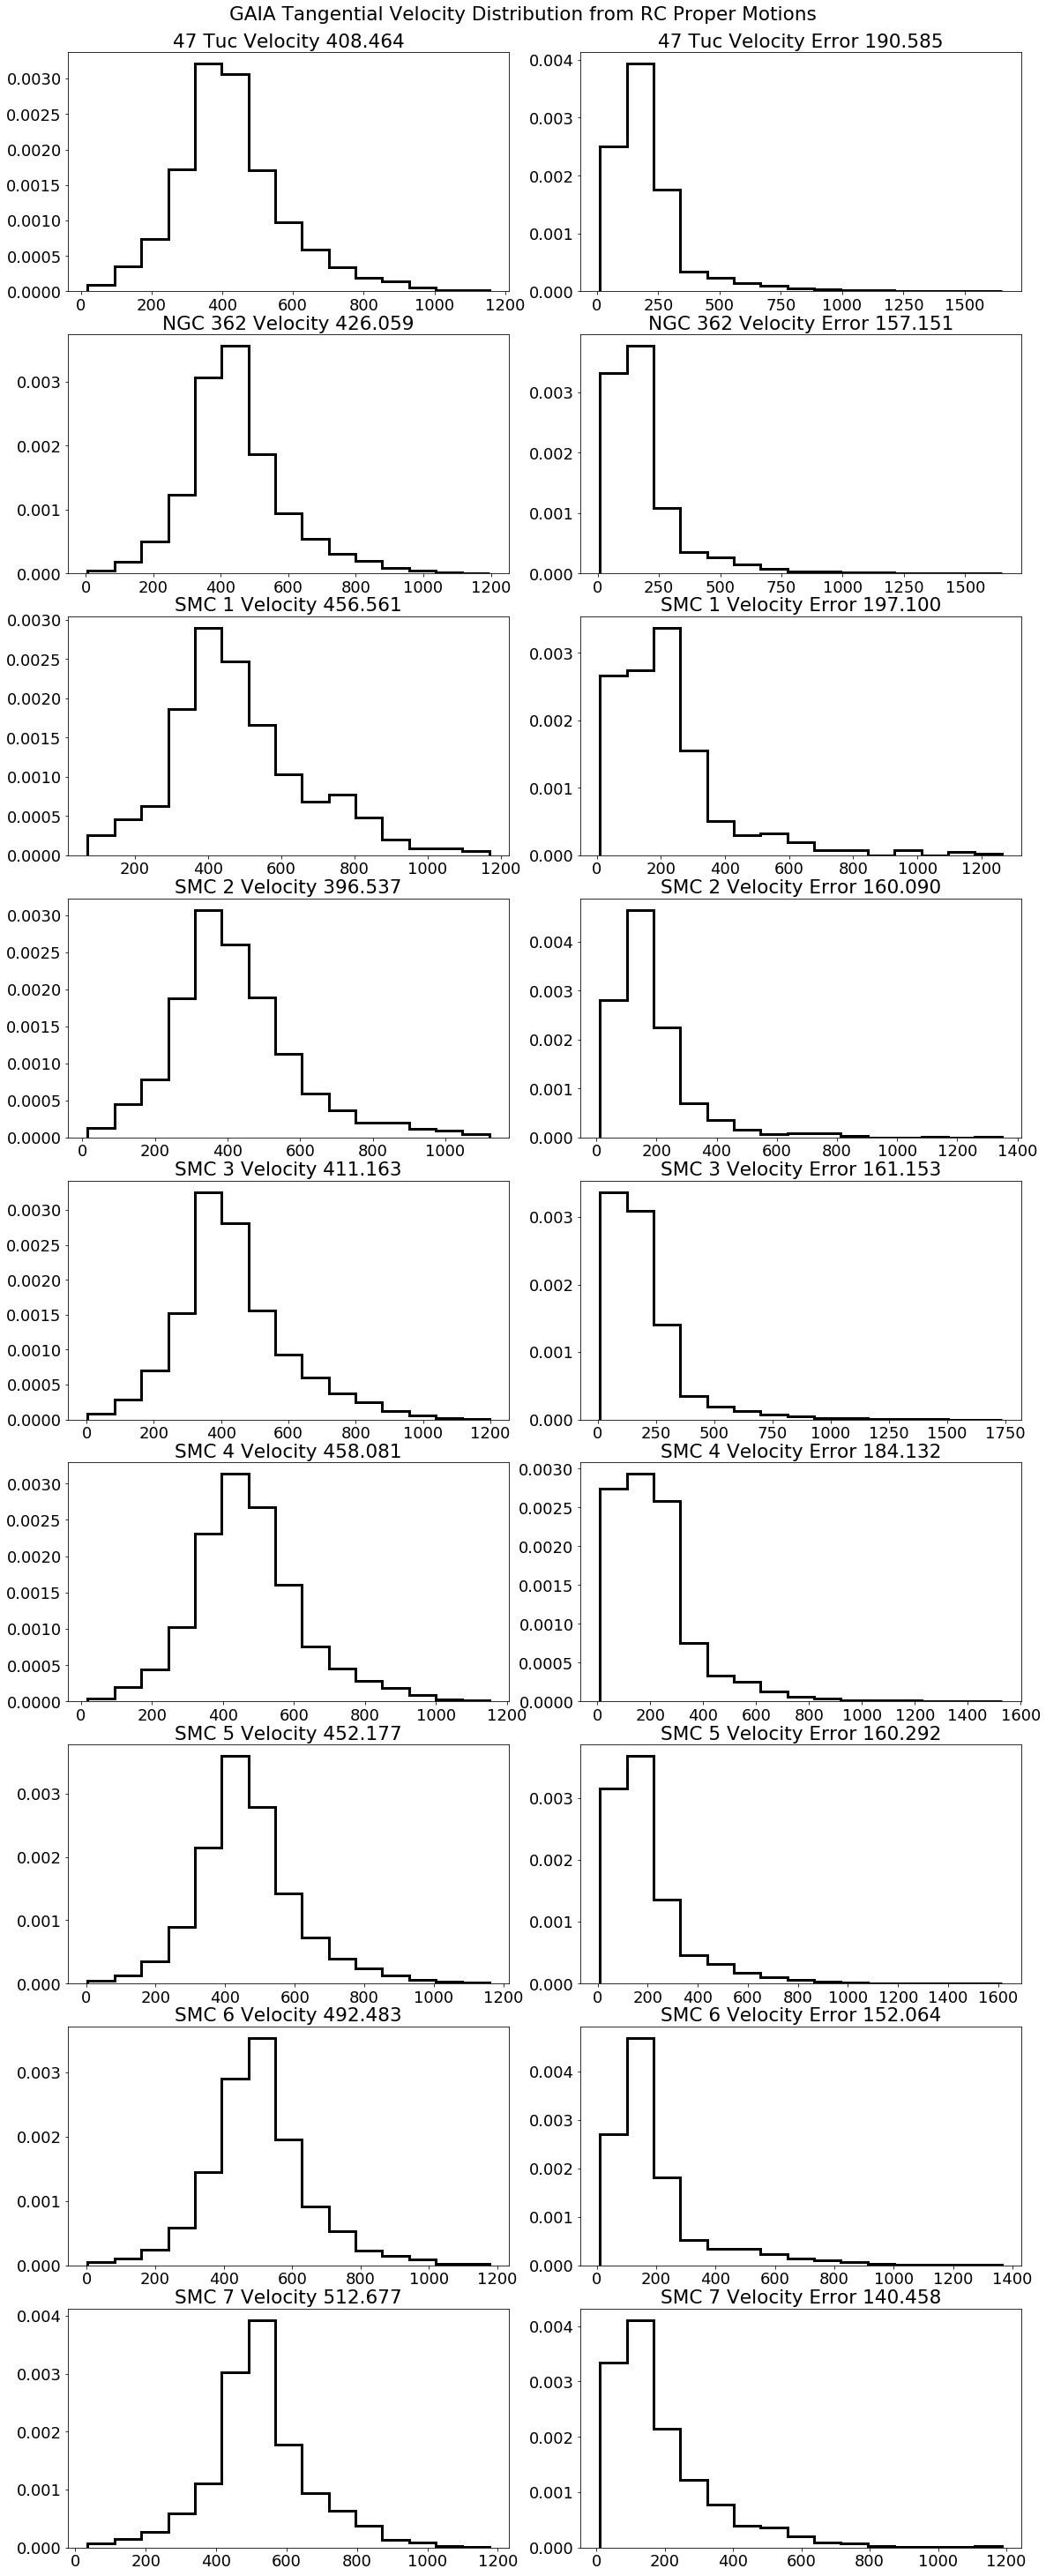

In [90]:
velocity_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,40])

for i in range(len(ax)):
    ax[i,0].hist(rc_vel_fields[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    ax[i,1].hist(rc_vel_fields_err[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    
#     ax[i,0].set_ylim(top=0.11)
#     ax[i,1].set_ylim(top=0.8)
    
#     ax[i,0].set_xlim(40,110)
#     ax[i,1].set_xlim(1,14)
    
    ax[i,0].set_title(r'{} Velocity {:.3f}'.format(velocity_label[i],np.median(rc_vel_fields[i])))
    ax[i,1].set_title(r'{} Velocity Error {:.3f}'.format(velocity_label[i],np.median(rc_vel_fields_err[i])))
    
#     ax[i,0].axvline(50,ls='--',c='b')
#     ax[i,0].axvline(60,ls='--',c='b')
#     ax[i,0].axvline(70,ls='--',c='b')

plt.suptitle(r'GAIA Tangential Velocity Distribution from RC Proper Motions',y=1.01)
plt.tight_layout(pad=0.1)

plt.show()

In [88]:
# use phot + offset

array([0.0737145, 0.056366 , 0.06635  , 0.0567719, 0.0413607, 0.0542161,
       0.0391498, 0.0592906, 0.0728594, 0.0605761, 0.0894573, 0.0583298,
       0.051193 , 0.0489138, 0.053545 , 0.0437445, 0.0596054, 0.0516519,
       0.0754019, 0.0658556, 0.0528907, 0.056771 , 0.0550536, 0.0640459,
       0.0612595, 0.0727058, 0.0495275, 0.0605221, 0.073584 , 0.059434 ,
       0.108203 , 0.0472364, 0.0527298, 0.0581875, 0.0650871, 0.0519742,
       0.0427379, 0.0598212, 0.0533657, 0.0516299, 0.0558167, 0.0449261,
       0.0760506, 0.0702174, 0.0519345, 0.0499958, 0.0605924, 0.0702487,
       0.0593814, 0.0532029, 0.0452654, 0.0463142, 0.064208 , 0.0628749,
       0.0772307, 0.0473764, 0.0601843, 0.0582329, 0.0591647, 0.0476289,
       0.0782111, 0.0859684, 0.0807945, 0.0922986, 0.0630295, 0.0550542,
       0.0795697, 0.0527125, 0.0522054, 0.0457846, 0.0919743, 0.0668002,
       0.0723768, 0.0780931, 0.0582879, 0.10068  , 0.0781032, 0.117228 ,
       0.074848 , 0.0475392, 0.0698608, 0.0471067, 

In [85]:
rv_mu_fields = [smc_nobloop[tuc47_ind]['VHELIO_AVG'],smc_nobloop[n362_ind]['VHELIO_AVG'],
                smc_nobloop[smc1_ind]['VHELIO_AVG'],smc_nobloop[smc2_ind]['VHELIO_AVG'],
                smc_nobloop[smc3_ind]['VHELIO_AVG'],smc_nobloop[smc4_ind]['VHELIO_AVG'],
                smc_nobloop[smc5_ind]['VHELIO_AVG'],smc_nobloop[smc6_ind]['VHELIO_AVG'],
                smc_nobloop[smc7_ind]['VHELIO_AVG']]

rv_mu_fields_err = [smc_nobloop[tuc47_ind]['VERR'],smc_nobloop[n362_ind]['VERR'],
                smc_nobloop[smc1_ind]['VERR'],smc_nobloop[smc2_ind]['VERR'],
                smc_nobloop[smc3_ind]['VERR'],smc_nobloop[smc4_ind]['VERR'],
                smc_nobloop[smc5_ind]['VERR'],smc_nobloop[smc6_ind]['VERR'],
                smc_nobloop[smc7_ind]['VERR']]

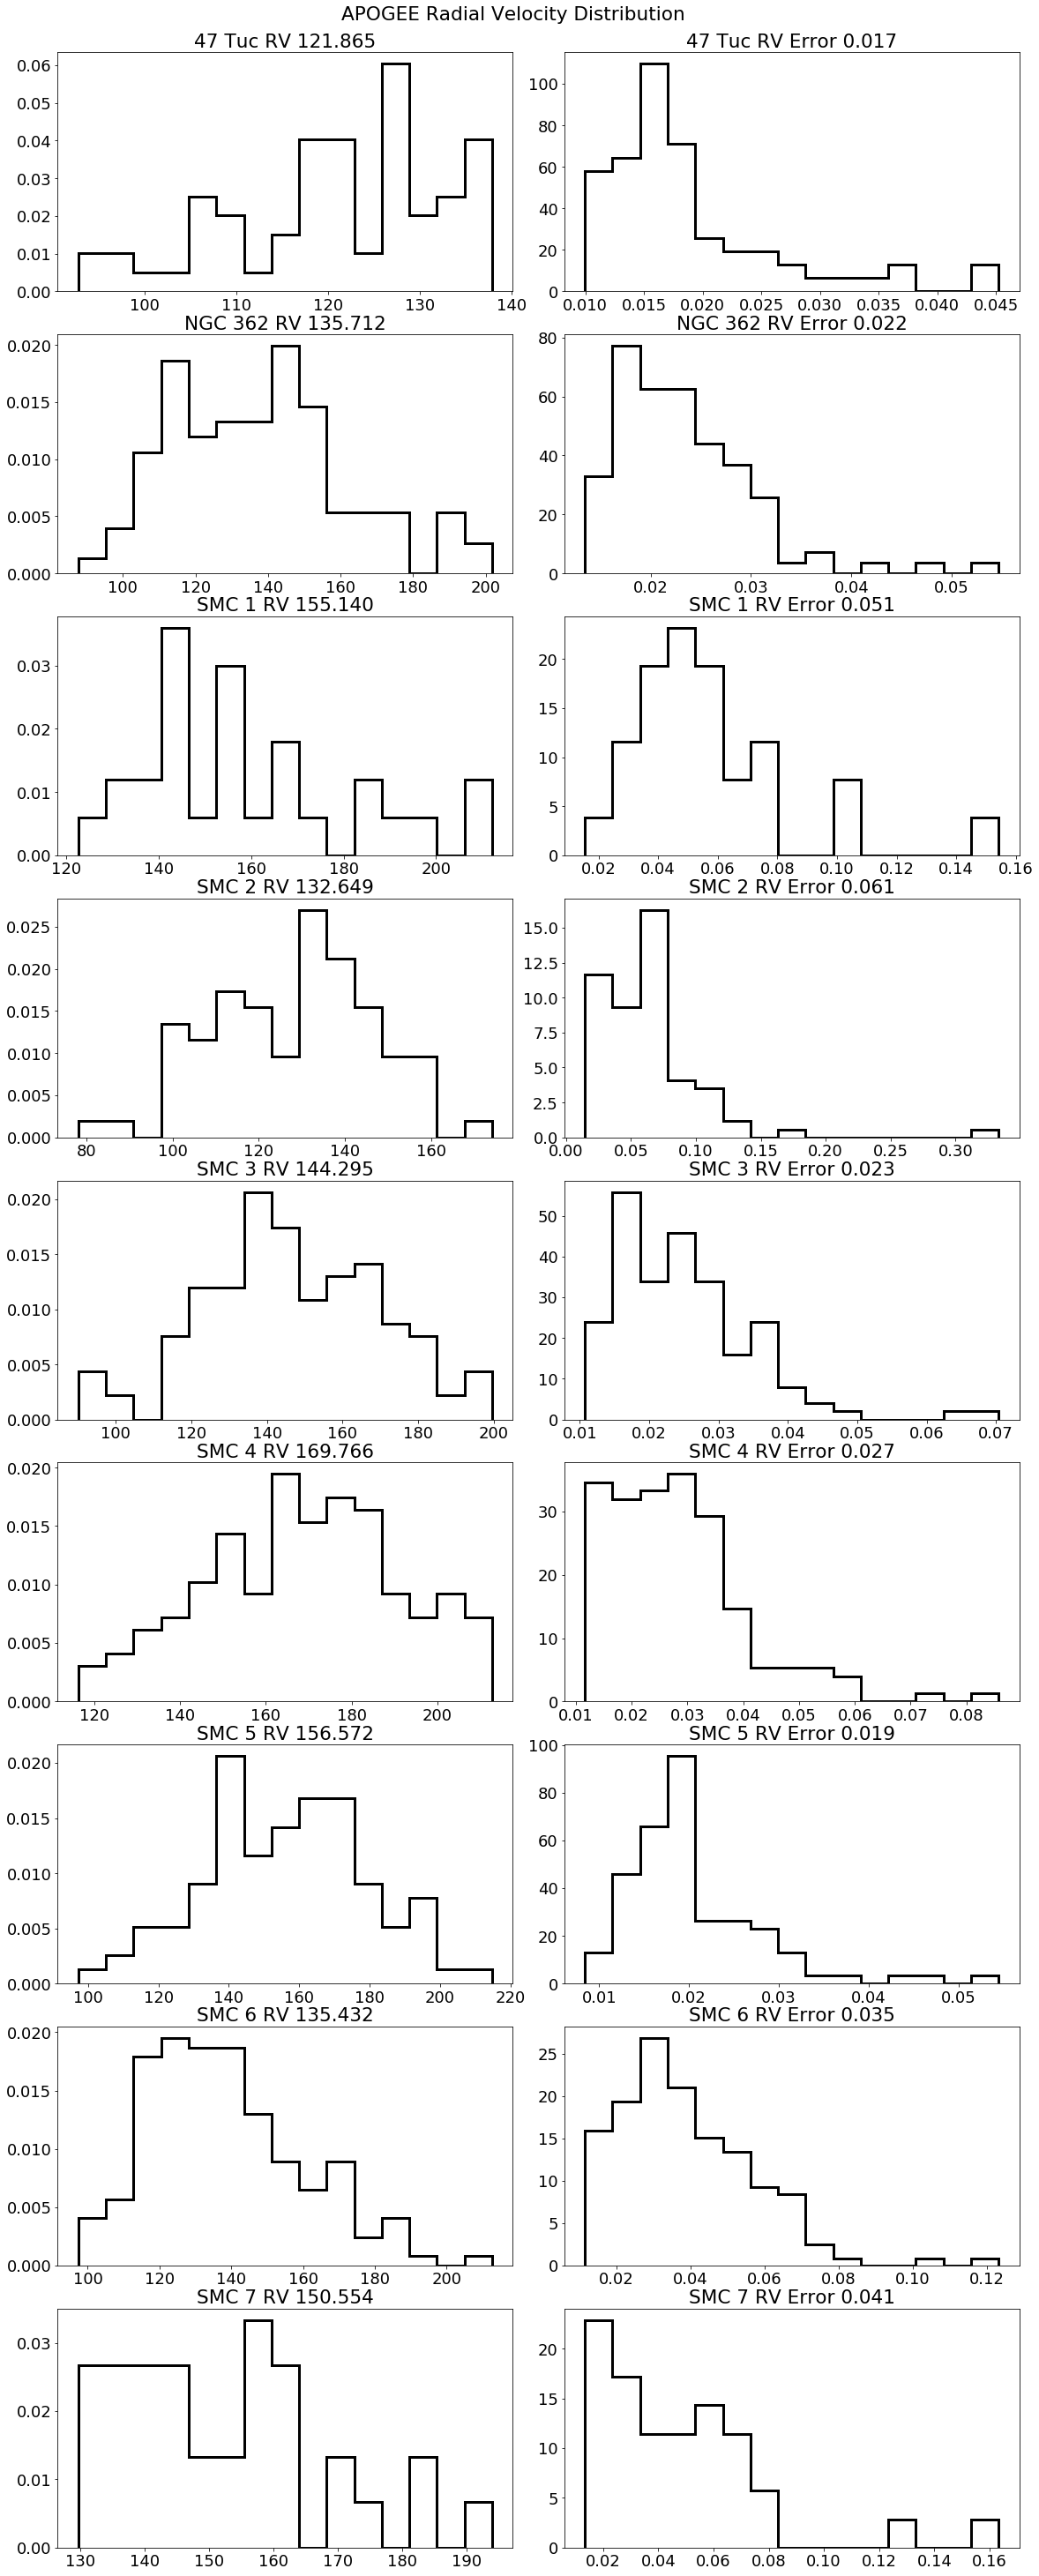

In [89]:
velocity_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,40])

for i in range(len(ax)):
    ax[i,0].hist(rv_mu_fields[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    ax[i,1].hist(rv_mu_fields_err[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    
#     ax[i,0].set_ylim(top=0.11)
#     ax[i,1].set_ylim(top=0.8)
    
#     ax[i,0].set_xlim(40,110)
#     ax[i,1].set_xlim(1,14)
    
    ax[i,0].set_title(r'{} RV {:.3f}'.format(velocity_label[i],np.median(rv_mu_fields[i])))
    ax[i,1].set_title(r'{} RV Error {:.3f}'.format(velocity_label[i],np.median(rv_mu_fields_err[i])))
    
#     ax[i,0].axvline(50,ls='--',c='b')
#     ax[i,0].axvline(60,ls='--',c='b')
#     ax[i,0].axvline(70,ls='--',c='b')

plt.suptitle(r'APOGEE Radial Velocity Distribution',y=1.01)
plt.tight_layout(pad=0.1)

plt.show()

In [92]:
vt_fields = np.array([np.sqrt(smc_nobloop[tuc47_ind]['GAIA_PMRA']**2+smc_nobloop[tuc47_ind]['GAIA_PMDEC']**2),
                      np.sqrt(smc_nobloop[n362_ind]['GAIA_PMRA']**2+smc_nobloop[n362_ind]['GAIA_PMDEC']**2),
                      np.sqrt(smc_nobloop[smc1_ind]['GAIA_PMRA']**2+smc_nobloop[smc1_ind]['GAIA_PMDEC']**2),
                      np.sqrt(smc_nobloop[smc2_ind]['GAIA_PMRA']**2+smc_nobloop[smc2_ind]['GAIA_PMDEC']**2),
                      np.sqrt(smc_nobloop[smc3_ind]['GAIA_PMRA']**2+smc_nobloop[smc3_ind]['GAIA_PMDEC']**2),
                      np.sqrt(smc_nobloop[smc4_ind]['GAIA_PMRA']**2+smc_nobloop[smc4_ind]['GAIA_PMDEC']**2),
                      np.sqrt(smc_nobloop[smc5_ind]['GAIA_PMRA']**2+smc_nobloop[smc5_ind]['GAIA_PMDEC']**2),
                      np.sqrt(smc_nobloop[smc6_ind]['GAIA_PMRA']**2+smc_nobloop[smc6_ind]['GAIA_PMDEC']**2),
                      np.sqrt(smc_nobloop[smc7_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[smc7_ind]['GAIA_PMDEC']**2)])*60*4.74

vt_fields_err = np.array([np.sqrt(smc_nobloop[tuc47_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[tuc47_ind]['GAIA_PMDEC_ERROR']**2),
                      np.sqrt(smc_nobloop[n362_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[n362_ind]['GAIA_PMDEC_ERROR']**2),
                      np.sqrt(smc_nobloop[smc1_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[smc1_ind]['GAIA_PMDEC_ERROR']**2),
                      np.sqrt(smc_nobloop[smc2_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[smc2_ind]['GAIA_PMDEC_ERROR']**2),
                      np.sqrt(smc_nobloop[smc3_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[smc3_ind]['GAIA_PMDEC_ERROR']**2),
                      np.sqrt(smc_nobloop[smc4_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[smc4_ind]['GAIA_PMDEC_ERROR']**2),
                      np.sqrt(smc_nobloop[smc5_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[smc5_ind]['GAIA_PMDEC_ERROR']**2),
                      np.sqrt(smc_nobloop[smc6_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[smc6_ind]['GAIA_PMDEC_ERROR']**2),
                      np.sqrt(smc_nobloop[smc7_ind]['GAIA_PMRA_ERROR']**2+smc_nobloop[smc7_ind]['GAIA_PMDEC_ERROR']**2)])*60*4.74


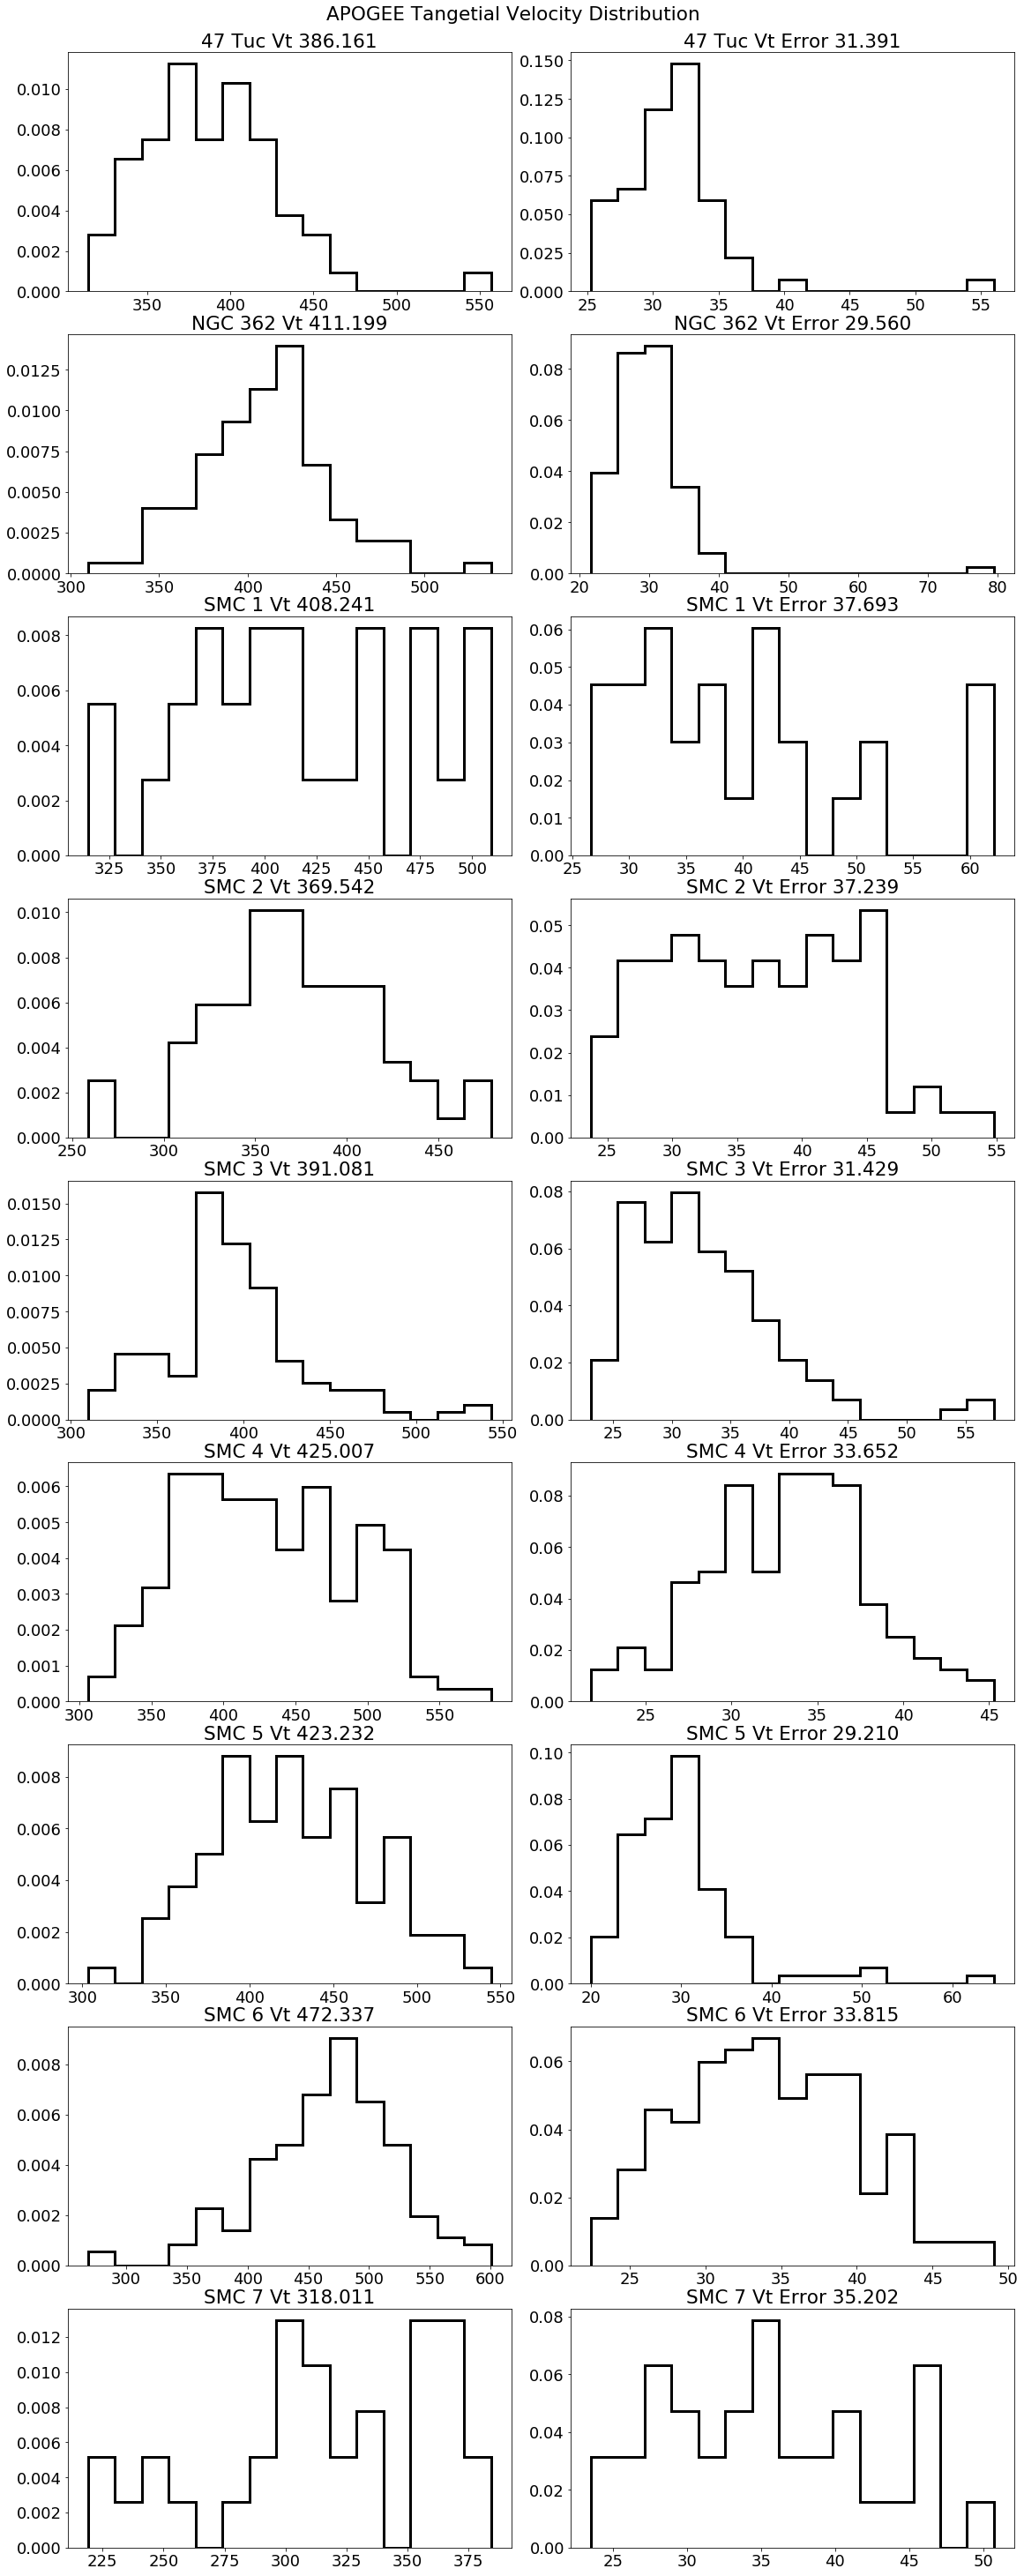

In [94]:
velocity_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,40])

for i in range(len(ax)):
    ax[i,0].hist(vt_fields[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    ax[i,1].hist(vt_fields_err[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    
#     ax[i,0].set_ylim(top=0.11)
#     ax[i,1].set_ylim(top=0.8)
    
#     ax[i,0].set_xlim(40,110)
#     ax[i,1].set_xlim(1,14)
    
    ax[i,0].set_title(r'{} Vt {:.3f}'.format(velocity_label[i],np.median(vt_fields[i])))
    ax[i,1].set_title(r'{} Vt Error {:.3f}'.format(velocity_label[i],np.median(vt_fields_err[i])))
    
#     ax[i,0].axvline(50,ls='--',c='b')
#     ax[i,0].axvline(60,ls='--',c='b')
#     ax[i,0].axvline(70,ls='--',c='b')

plt.suptitle(r'APOGEE Tangetial Velocity Distribution',y=1.01)
plt.tight_layout(pad=0.1)

plt.show()

<font size='45'>
    <b>
        Proper Motion Dispersion
    </b>
</font>

In [7]:
mu = np.sqrt(np.square(smc_nobloop['GAIA_PMRA'])+np.square(smc_nobloop['GAIA_PMDEC']))
mu_err = np.sqrt(np.square(smc_nobloop['GAIA_PMRA_ERROR'])+np.square(smc_nobloop['GAIA_PMDEC_ERROR']))

In [8]:
med_pm_dists = []
for i in tqdm_notebook(range(20)):
    individ_dist = []
    for j in range(200):
        individ_dist.append(distance(util.add_noise(np.median(mu),np.median(mu_err)),np.median(rc_pmmag),60.))
        
    med_pm_dists.append(individ_dist)

med_pm_dists = np.asarray(med_pm_dists)



In [49]:
print(util.mad(rc_pmmag)*60*4.74)
# print(np.std(rc_pmmag))

102.60260561560355


203.0558988805464

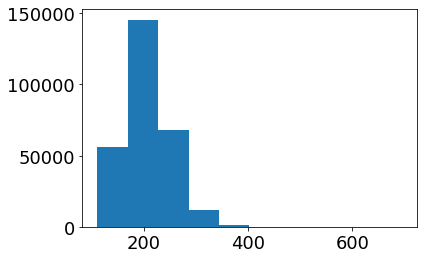

In [52]:
plt.hist(rc_pmmag_uncertainty*60*4.74)
np.median(rc_pmmag_uncertainty)*60*4.74

In [46]:
#\sigma_v = 4.74*|\mu''|\sigma_\mu''

sigma_v = 4.74*(util.mad(rc_pmmag))*60

fwhm_v = 2.355*sigma_v
fwhm_v

241.62913622474636

In [11]:
#use propagation of errors to see

(array([0.01063645, 0.04349831, 0.06016737, 0.02889304, 0.01016019,
        0.00206379, 0.00095252, 0.00063501, 0.        , 0.00015875]),
 array([15.84041192, 22.20313456, 28.56585719, 34.92857982, 41.29130245,
        47.65402509, 54.01674772, 60.37947035, 66.74219298, 73.10491562,
        79.46763825]),
 <a list of 1 Patch objects>)

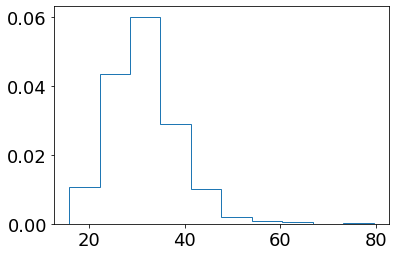

In [32]:
plt.hist(4.74*60*np.sqrt(smc['GAIA_PMRA_ERROR']**2+smc['GAIA_PMDEC_ERROR']**2),density=True,histtype='step')

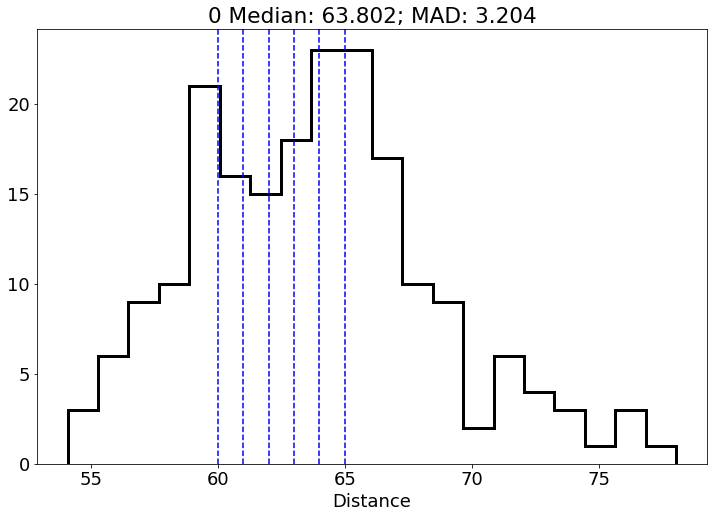

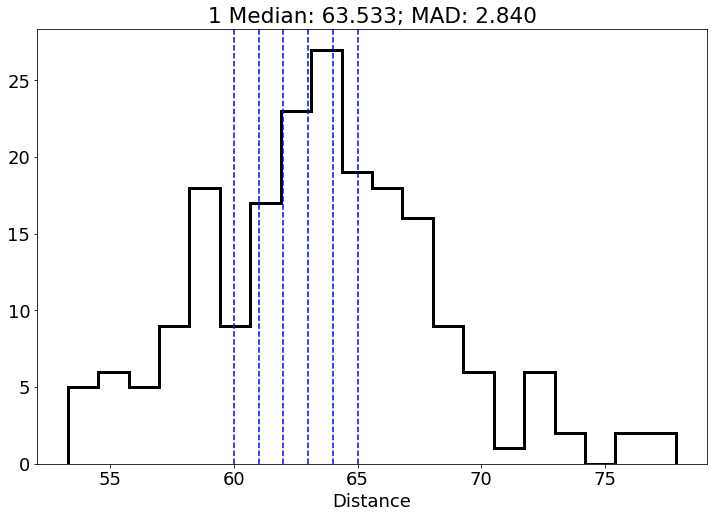

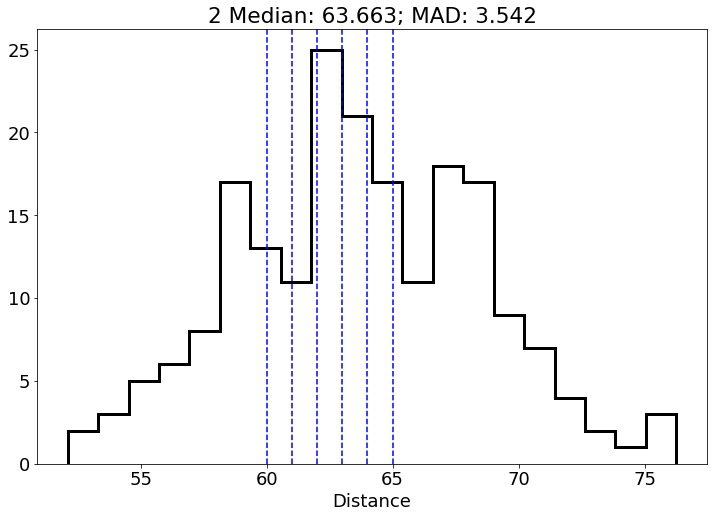

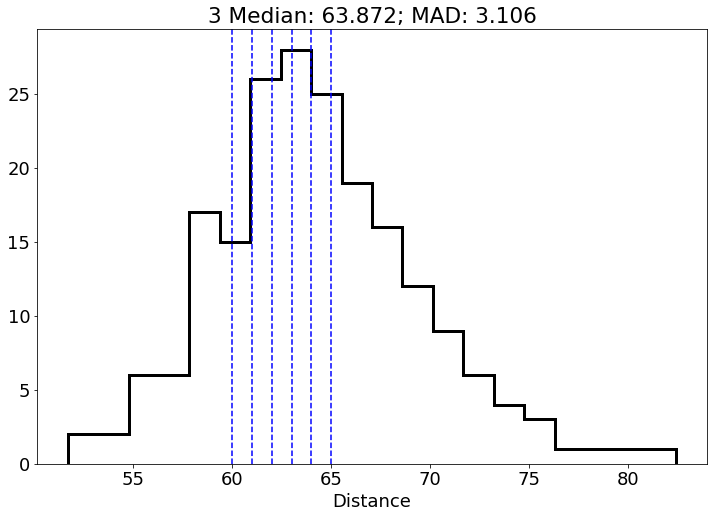

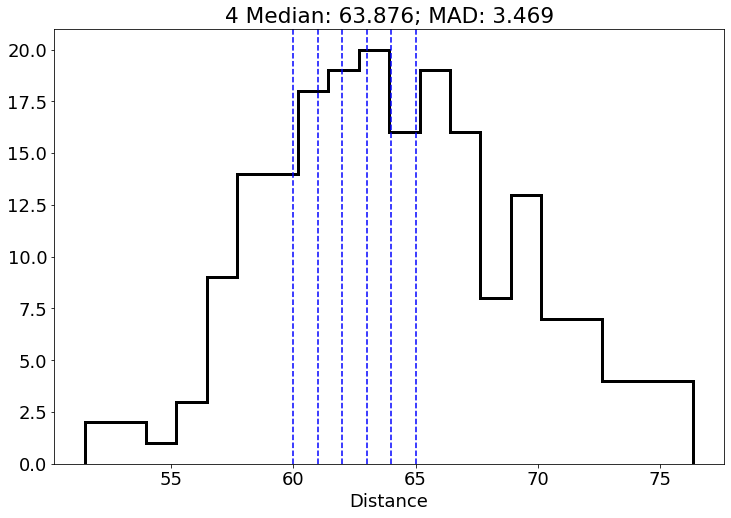

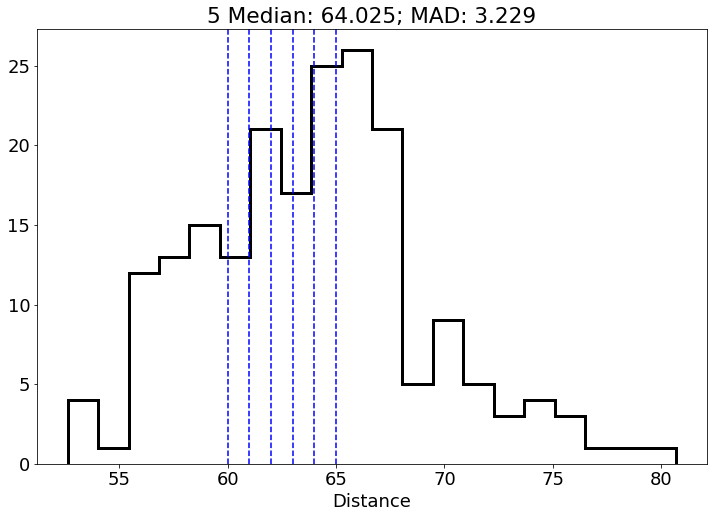

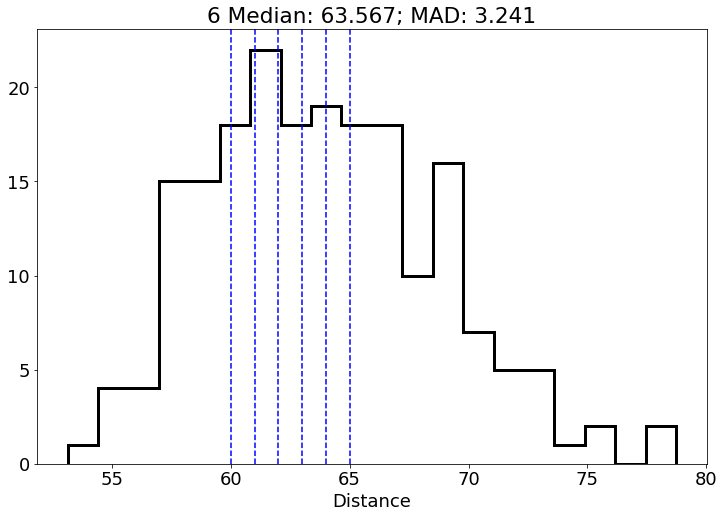

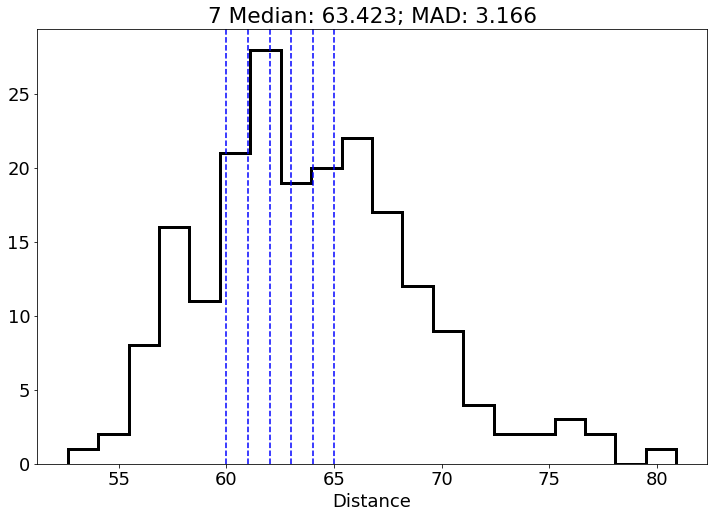

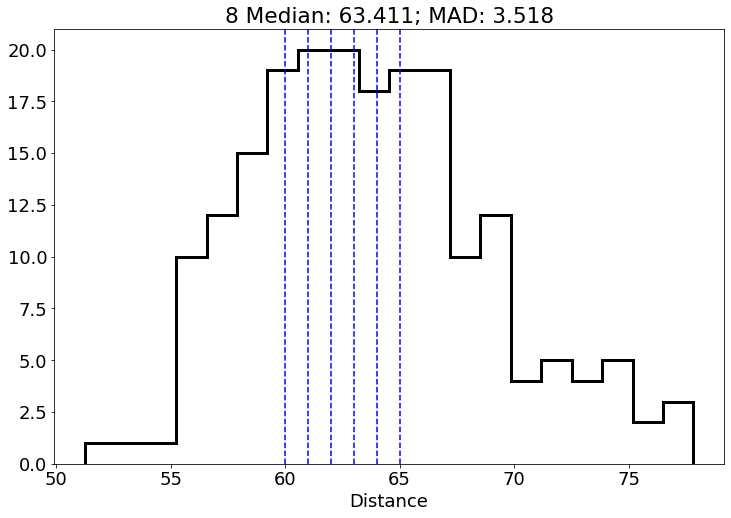

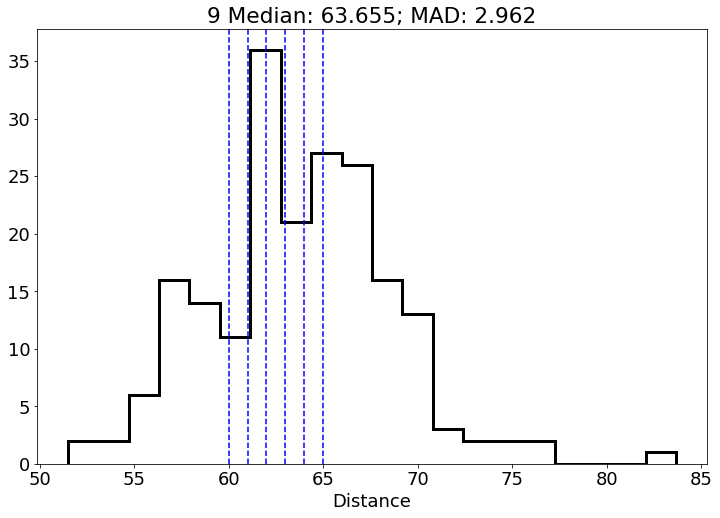

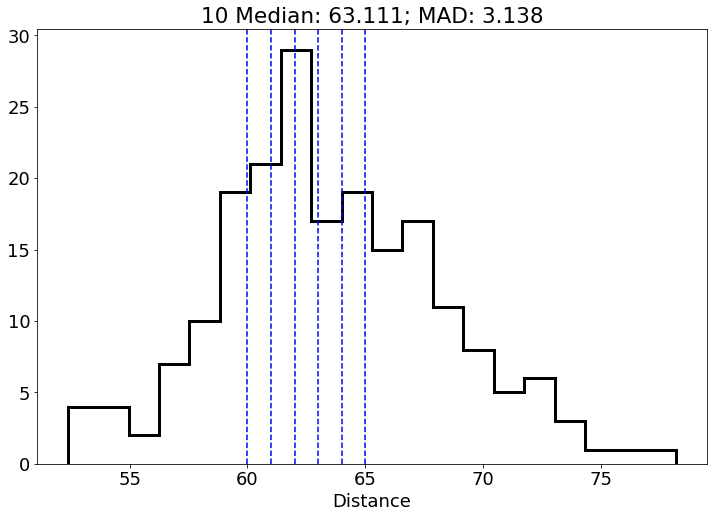

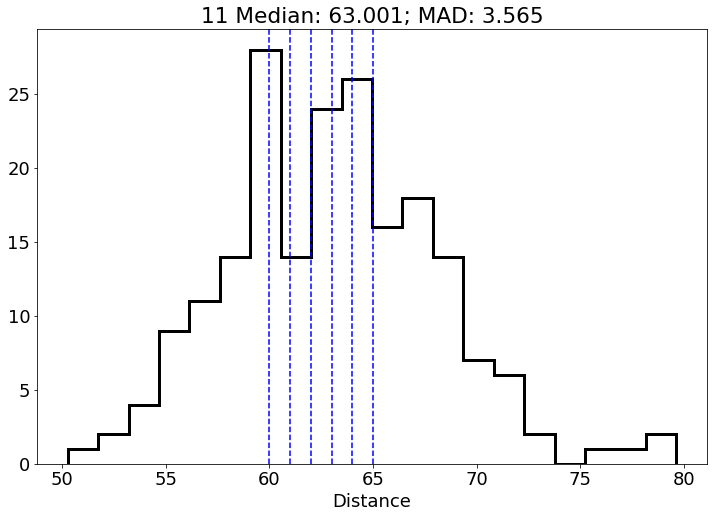

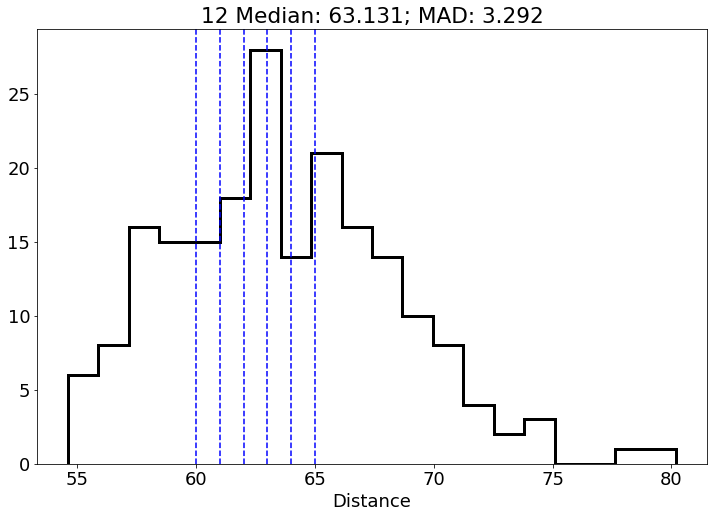

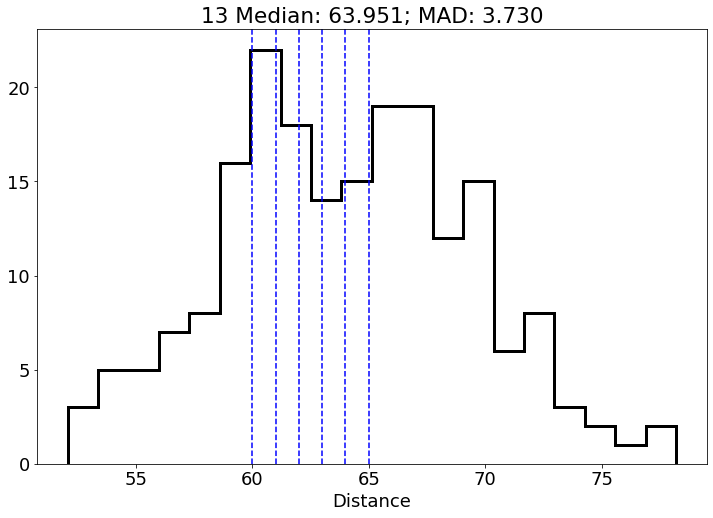

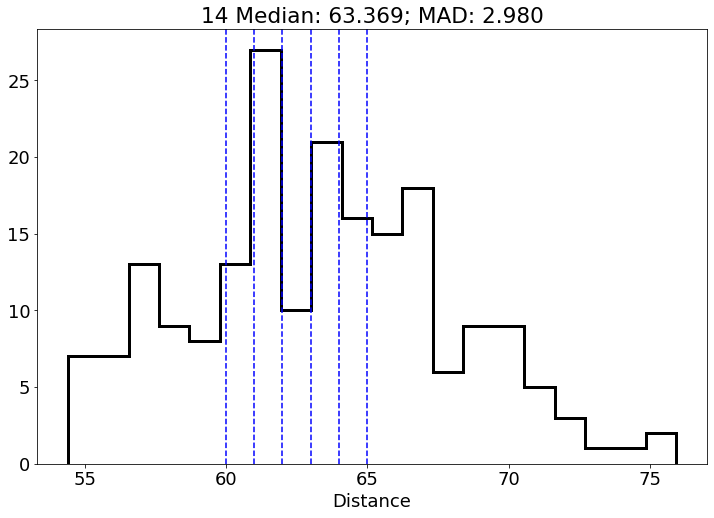

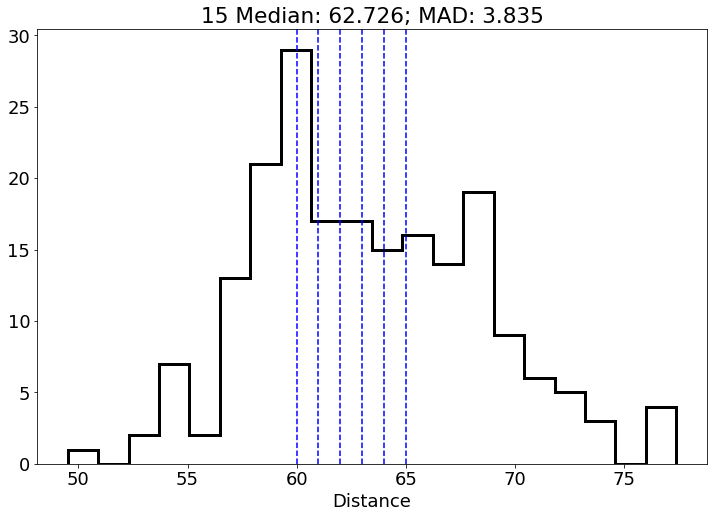

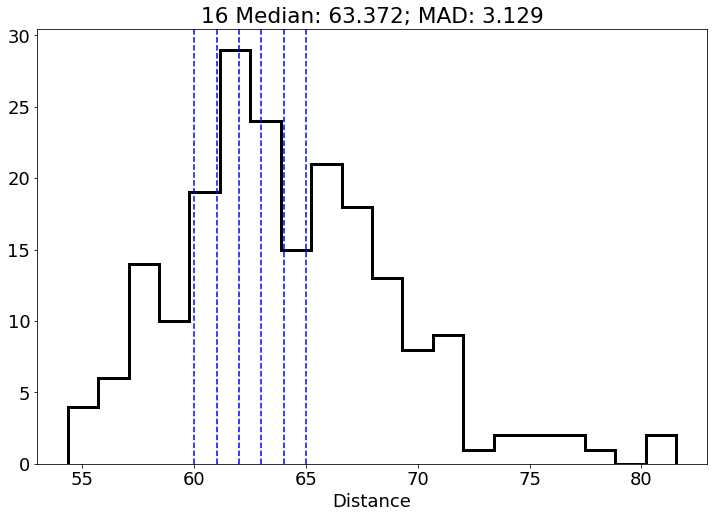

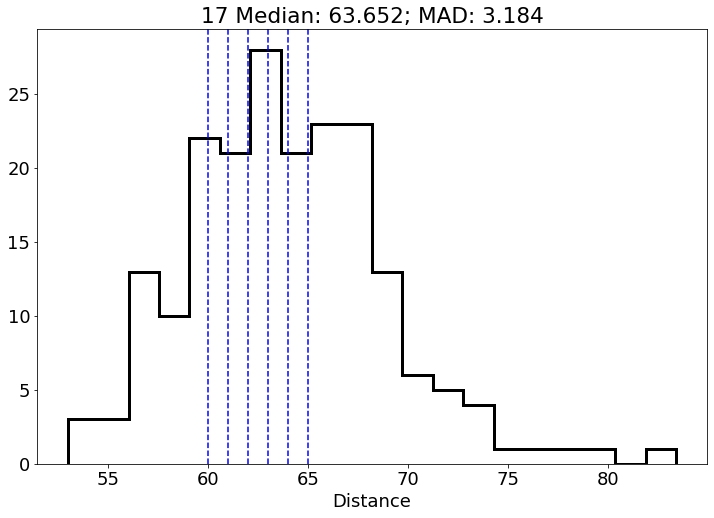

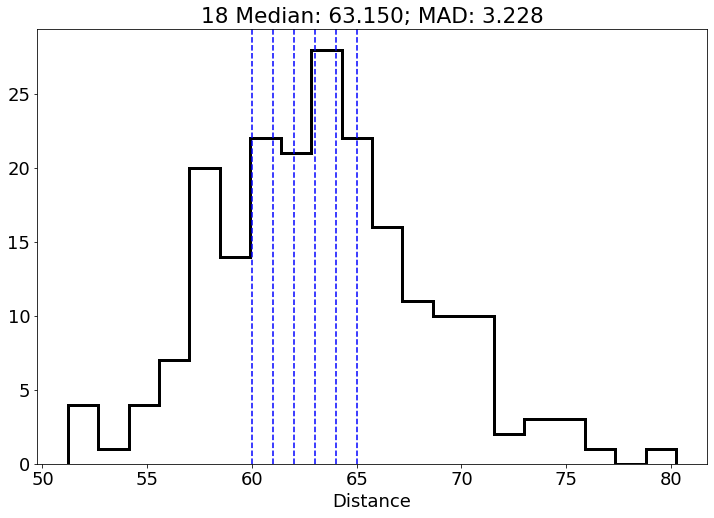

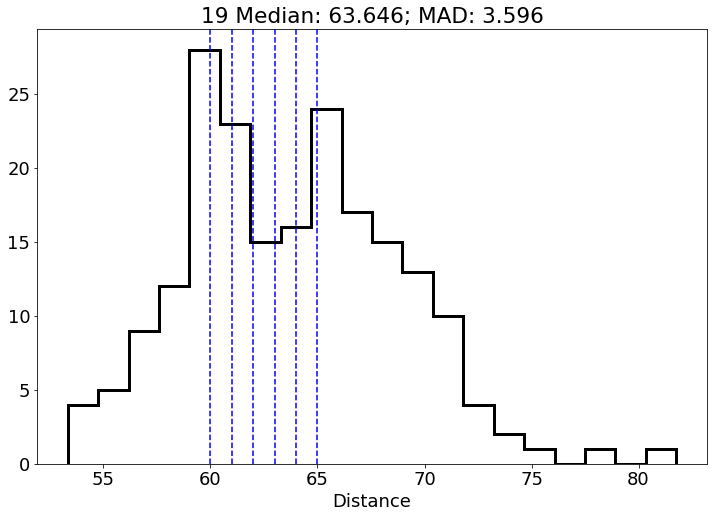

In [12]:
for i in range(len(med_pm_dists)):
    plt.figure(figsize=[12,8])
    plt.hist(med_pm_dists[i],histtype='step',color='k',lw='3.0',bins=20)
#     plt.grid()
    
    for j in [60,61,62,63,64,65]:
        plt.axvline(float(j),c='b',ls='--')
#     plt.axvline(60.,c='b',ls='--')
#     plt.axvline(61.,c='b',ls='--')
#     plt.axvline(62.,c='b',ls='--')
#     plt.
    
    plt.title(r'{} Median: {:.3f}; MAD: {:.3f}'.format(i,np.median(med_pm_dists[i]),util.mad(med_pm_dists[i])))
    plt.xlabel(r'Distance')

In [13]:
distance_dist_pm = []
for i in tqdm_notebook(range(len(smc_nobloop))):
#     mu = np.sqrt(smc_nobloop['GAIA_PMRA'][i]**2+smc_nobloop['GAIA_PMDEC'][i]**2)
#     mu_err = np.sqrt(smc_nobloop['GAIA_PMRA_ERROR'][i]**2+smc_nobloop['GAIA_PMDEC_ERROR'][i]**2)
    
    dist = []
    for j in range(200):
        dist.append(distance(util.add_noise(mu[i],mu_err[i]),np.median(rc_pmmag),60.))
    
    distance_dist_pm.append(dist)

In [14]:
distance_pm = []
distance_pm_err = []
for i in tqdm_notebook(range(len(distance_dist_pm))):
    distance_pm.append(np.median(distance_dist_pm[i]))
    distance_pm_err.append(util.mad(distance_dist_pm[i]))
    
distance_pm = np.asarray(distance_pm)
distance_pm_err  = np.asarray(distance_pm_err)

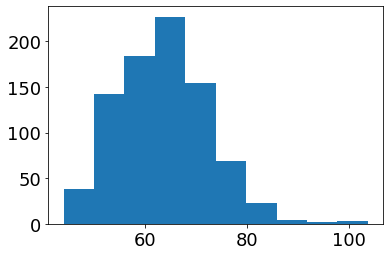

Mean MAD:  3.4863509636222605


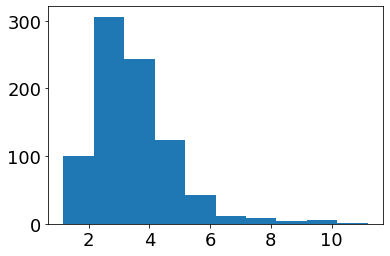

In [15]:
plt.hist(np.asarray(distance_pm))
plt.show()

plt.figure()
plt.hist(np.asarray(distance_pm_err))
print('Mean MAD: ',np.mean(distance_pm_err))
plt.show()

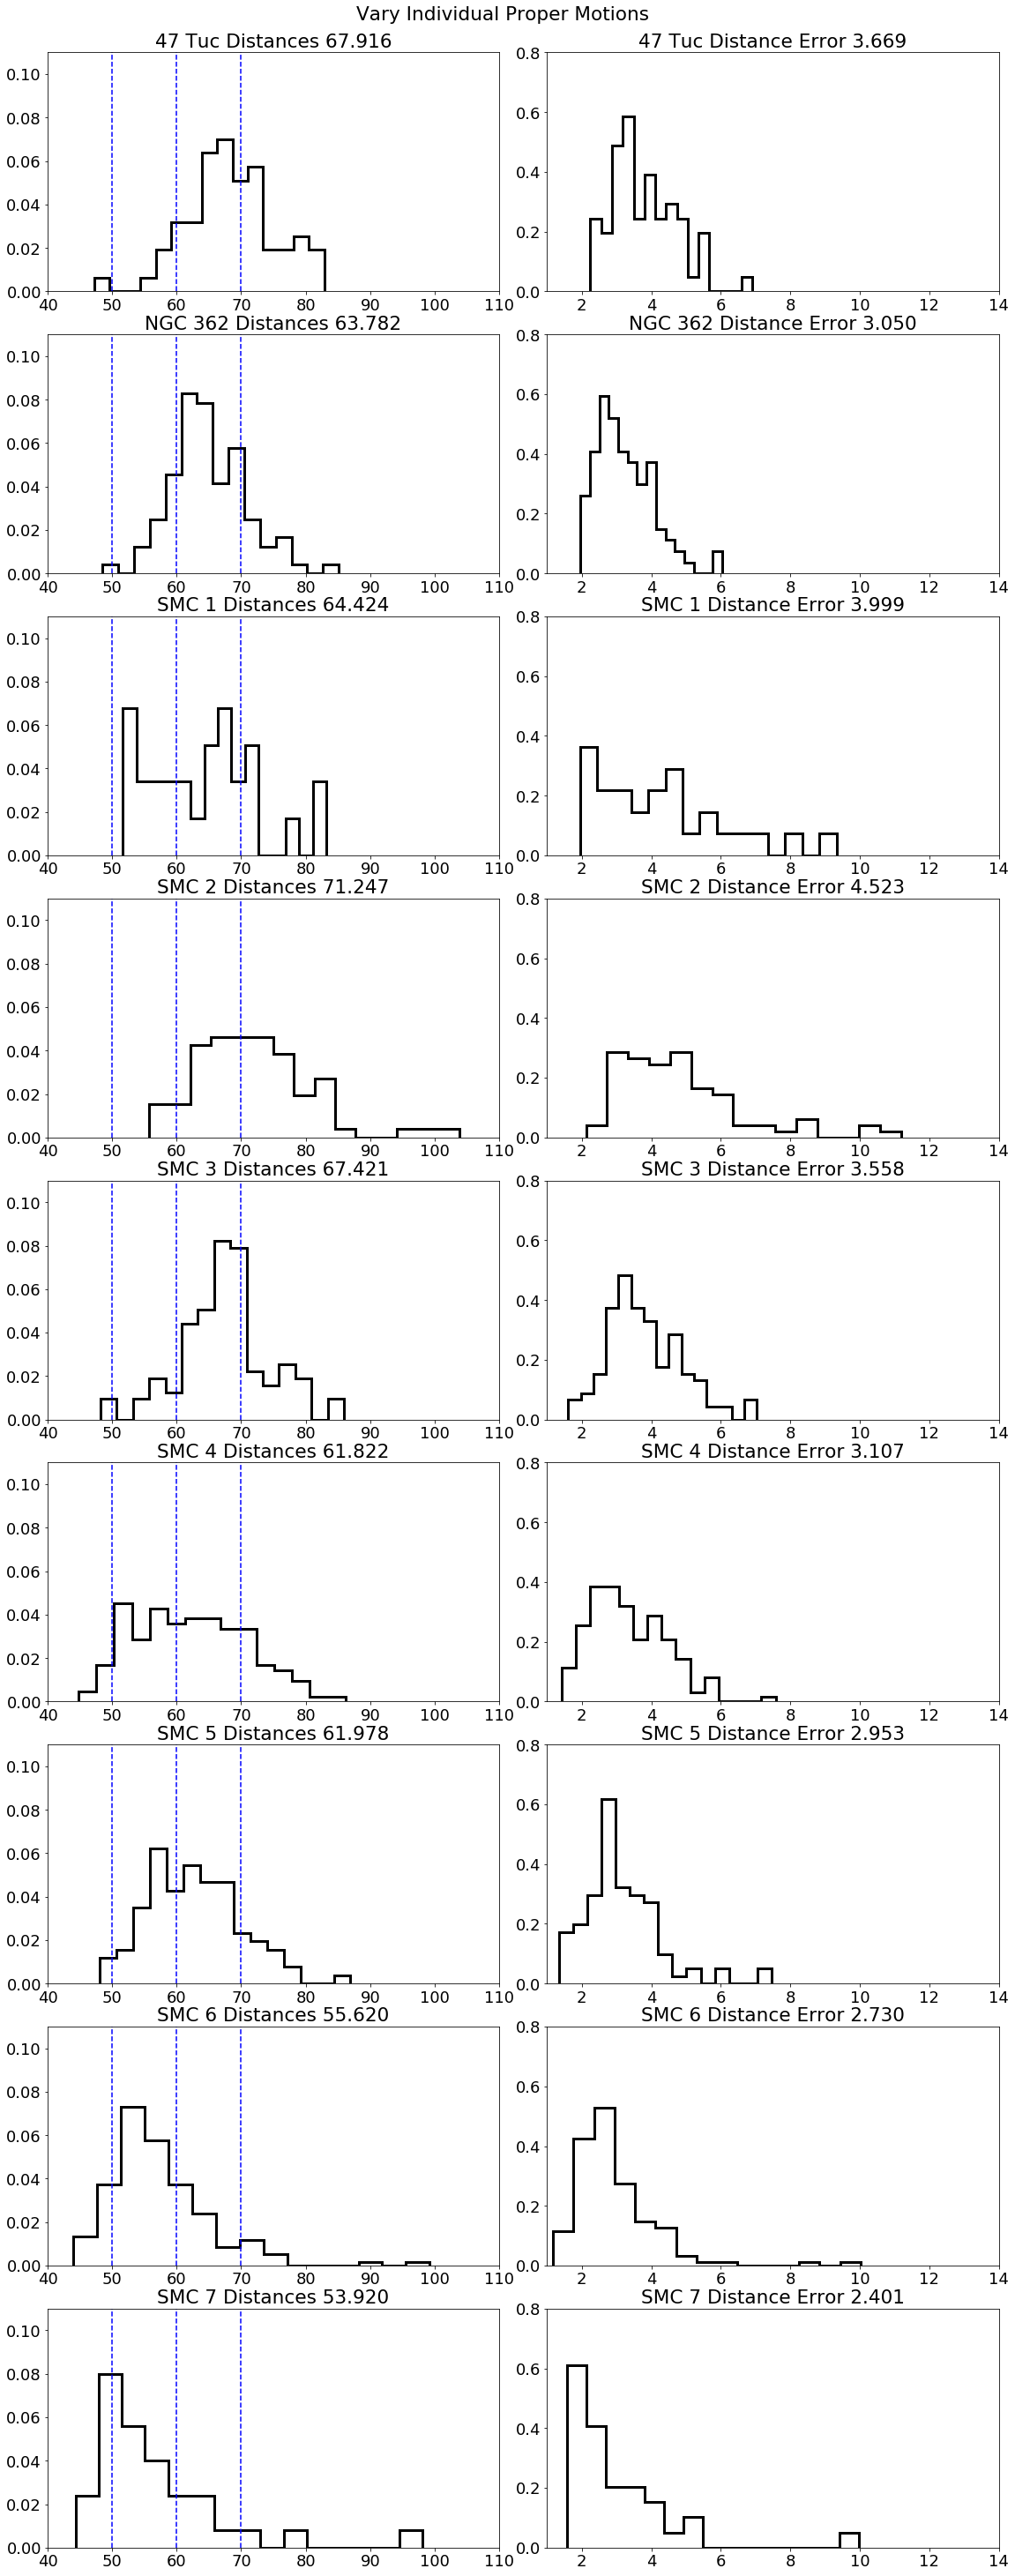

In [95]:
distance_list = [distance_pm[tuc47_ind],distance_pm[n362_ind],distance_pm[smc1_ind],distance_pm[smc2_ind],
                 distance_pm[smc3_ind],distance_pm[smc4_ind],distance_pm[smc5_ind],distance_pm[smc6_ind],
                 distance_pm[smc7_ind]]
distance_err_list = [distance_pm_err[tuc47_ind],distance_pm_err[n362_ind],distance_pm_err[smc1_ind],
                     distance_pm_err[smc2_ind],distance_pm_err[smc3_ind],distance_pm_err[smc4_ind],
                     distance_pm_err[smc5_ind],distance_pm_err[smc6_ind],distance_pm_err[smc7_ind]]
distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,40])

for i in range(len(ax)):
    ax[i,0].hist(distance_list[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    ax[i,1].hist(distance_err_list[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    
    ax[i,0].set_ylim(top=0.11)
    ax[i,1].set_ylim(top=0.8)
    
    ax[i,0].set_xlim(40,110)
    ax[i,1].set_xlim(1,14)
    
    ax[i,0].set_title(r'{} Distances {:.3f}'.format(distance_label[i],np.median(distance_list[i])))
    ax[i,1].set_title(r'{} Distance Error {:.3f}'.format(distance_label[i],np.median(distance_err_list[i])))
    
    ax[i,0].axvline(50,ls='--',c='b')
    ax[i,0].axvline(60,ls='--',c='b')
    ax[i,0].axvline(70,ls='--',c='b')

plt.suptitle(r'Vary Individual Proper Motions',y=1.01)
plt.tight_layout(pad=0.1)

plt.show()

<font size='45'>
    <b>
        Red Clump Dispersion
    </b>
</font>

In [17]:
# test = []
# for i in range(100):
#     test.append(util.add_noise(np.median(rc_pmmag),rc_pmmag_err))
    
# test

In [18]:
distance_dist_rc = []
for i in tqdm_notebook(range(len(smc_nobloop))):
    mu = np.sqrt(smc_nobloop['GAIA_PMRA'][i]**2+smc_nobloop['GAIA_PMDEC'][i]**2)
    mu_err = np.sqrt(smc_nobloop['GAIA_PMRA_ERROR'][i]**2+smc_nobloop['GAIA_PMDEC_ERROR'][i]**2)
    
    dist = []
    for j in range(200):
        dist.append(distance(mu,util.add_noise(np.median(rc_pmmag),rc_pmmag_err),60.))
    
    distance_dist_rc.append(dist)

In [19]:
distance_rc = []
distance_rc_err = []
for i in tqdm_notebook(range(len(distance_dist_rc))):
    distance_rc.append(np.median(distance_dist_rc[i]))
    distance_rc_err.append(util.mad(distance_dist_rc[i]))
    
distance_rc = np.asarray(distance_rc)
distance_rc_err = np.asarray(distance_rc_err)

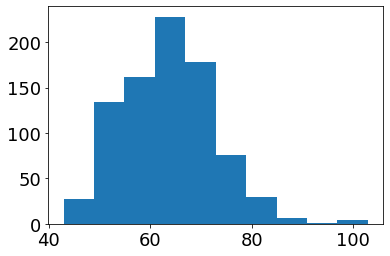

Mean MAD:  9.971763311417318


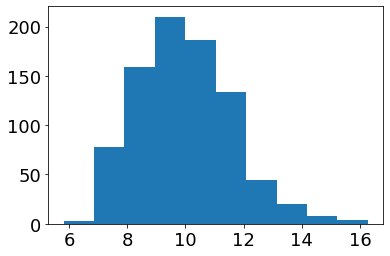

In [20]:
plt.hist(np.asarray(distance_rc))
plt.show()

plt.figure()
plt.hist(np.asarray(distance_rc_err))
print('Mean MAD: ',np.mean(distance_rc_err))
plt.show()

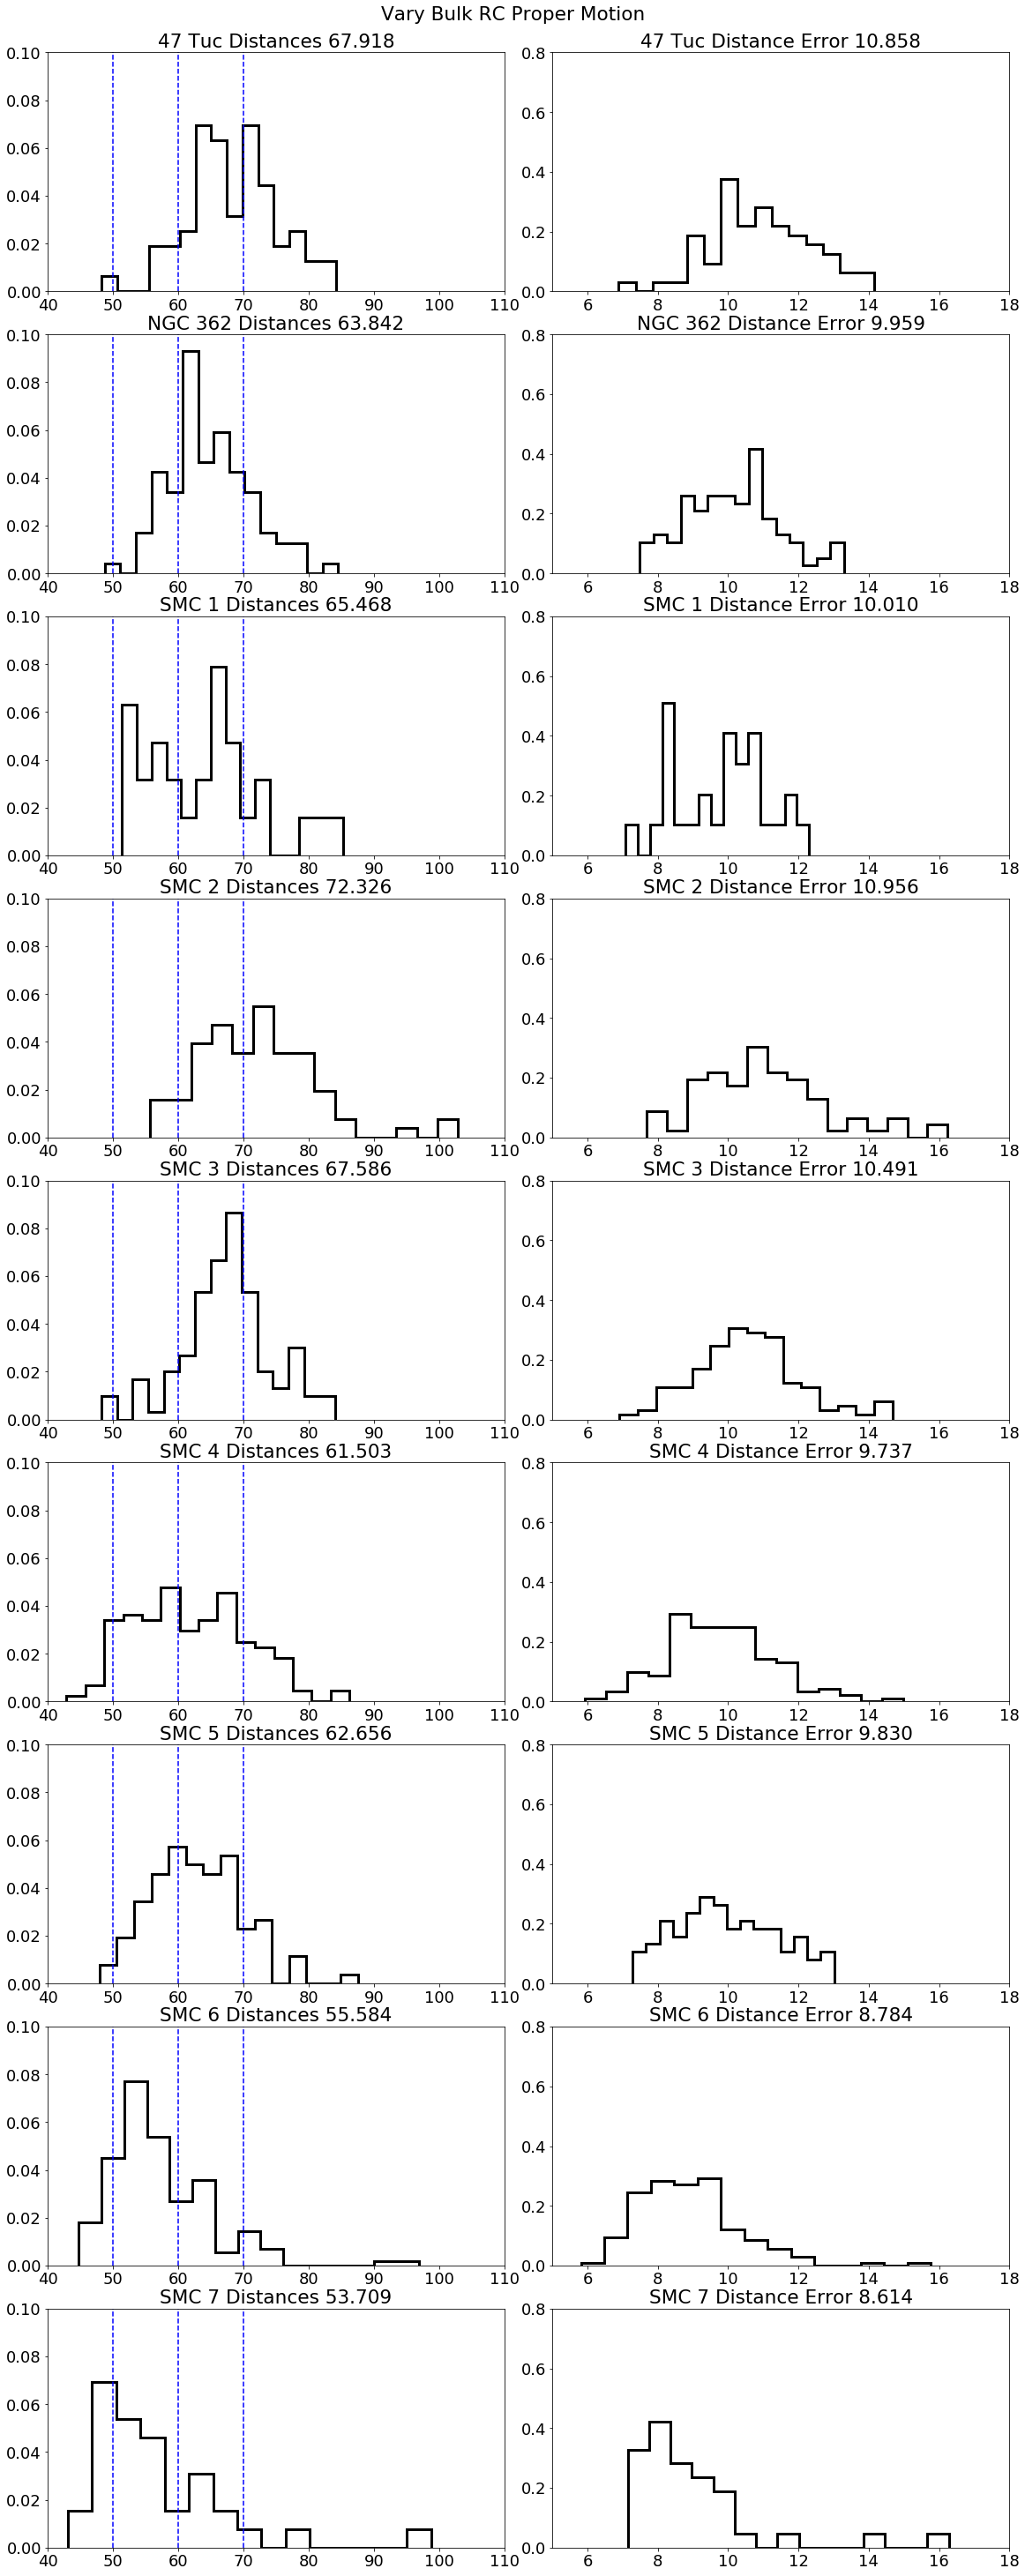

In [21]:
distance_rc_list = [distance_rc[tuc47_ind],distance_rc[n362_ind],distance_rc[smc1_ind],distance_rc[smc2_ind],
                 distance_rc[smc3_ind],distance_rc[smc4_ind],distance_rc[smc5_ind],distance_rc[smc6_ind],
                 distance_rc[smc7_ind]]
distance_rc_err_list = [distance_rc_err[tuc47_ind],distance_rc_err[n362_ind],distance_rc_err[smc1_ind],
                     distance_rc_err[smc2_ind],distance_rc_err[smc3_ind],distance_rc_err[smc4_ind],
                     distance_rc_err[smc5_ind],distance_rc_err[smc6_ind],distance_rc_err[smc7_ind]]
# distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,40])

for i in range(len(ax)):
    ax[i,0].hist(distance_rc_list[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    ax[i,1].hist(distance_rc_err_list[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    
    ax[i,0].set_ylim(top=0.1)
    ax[i,1].set_ylim(top=0.8)
    
    ax[i,0].set_xlim(40,110)
    ax[i,1].set_xlim(5,18)
    
    ax[i,0].set_title(r'{} Distances {:.3f}'.format(distance_label[i],np.median(distance_rc_list[i])))
    ax[i,1].set_title(r'{} Distance Error {:.3f}'.format(distance_label[i],np.median(distance_rc_err_list[i])))
    
    ax[i,0].axvline(50,ls='--',c='b')
    ax[i,0].axvline(60,ls='--',c='b')
    ax[i,0].axvline(70,ls='--',c='b')

plt.suptitle(r'Vary Bulk RC Proper Motion',y=1.01)
plt.tight_layout(pad=0.1)

plt.show()

<font size='45'>
    <b>
        Red Clump + Proper Motion Dispersion
    </b>
</font>

In [22]:
mu = np.sqrt(np.square(smc_nobloop['GAIA_PMRA'])+np.square(smc_nobloop['GAIA_PMDEC']))
mu_err = np.sqrt(np.square(smc_nobloop['GAIA_PMRA_ERROR'])+np.square(smc_nobloop['GAIA_PMDEC_ERROR']))

distance_dist_pm_rc = []
for i in tqdm_notebook(range(len(smc_nobloop))):
#     mu = np.sqrt(smc_nobloop['GAIA_PMRA'][i]**2+smc_nobloop['GAIA_PMDEC'][i]**2)
#     mu_err = np.sqrt(smc_nobloop['GAIA_PMRA_ERROR'][i]**2+smc_nobloop['GAIA_PMDEC_ERROR'][i]**2)
    
    dist = []
    for j in range(200):
        dist.append(distance(util.add_noise(mu[i],mu_err[i]),
                             util.add_noise(np.median(rc_pmmag),rc_pmmag_err),60.))
    
    distance_dist_pm_rc.append(dist)

In [23]:
# distance_pm_rc = []
# distance_pm_rc_err = []
# for i in tqdm_notebook(range(len(distance_dist_pm_rc))):
#     distance_pm_rc.append(np.median(distance_dist_pm_rc[i]))
#     distance_pm_rc_err.append(util.mad(distance_dist_pm_rc[i]))
    
# distance_pm_rc = np.asarray(distance_dist_pm_rc)
# distance_pm_rc_err = np.asarray(distance_pm_rc_err)

distance_pm_rc = []
distance_pm_rc_err = []
for i in tqdm_notebook(range(len(distance_dist_pm_rc))):
    distance_pm_rc.append(np.median(distance_dist_pm_rc[i]))
    distance_pm_rc_err.append(util.mad(distance_dist_pm_rc[i]))
    
distance_pm_rc = np.asarray(distance_pm_rc)
distance_pm_rc_err = np.asarray(distance_pm_rc_err)

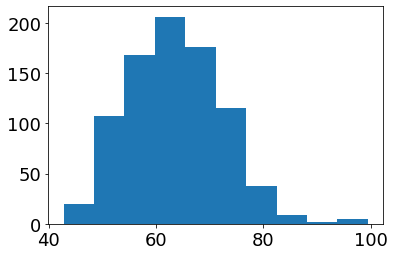

Mean MAD:  10.651160087785435


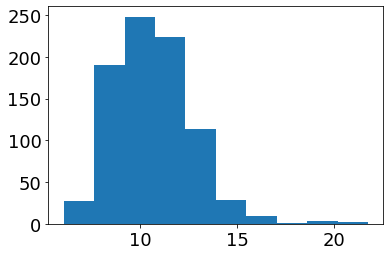

In [24]:
plt.hist(np.asarray(distance_pm_rc))
plt.show()

plt.figure()
plt.hist(np.asarray(distance_pm_rc_err))
print('Mean MAD: ',np.mean(distance_pm_rc_err))
plt.show()

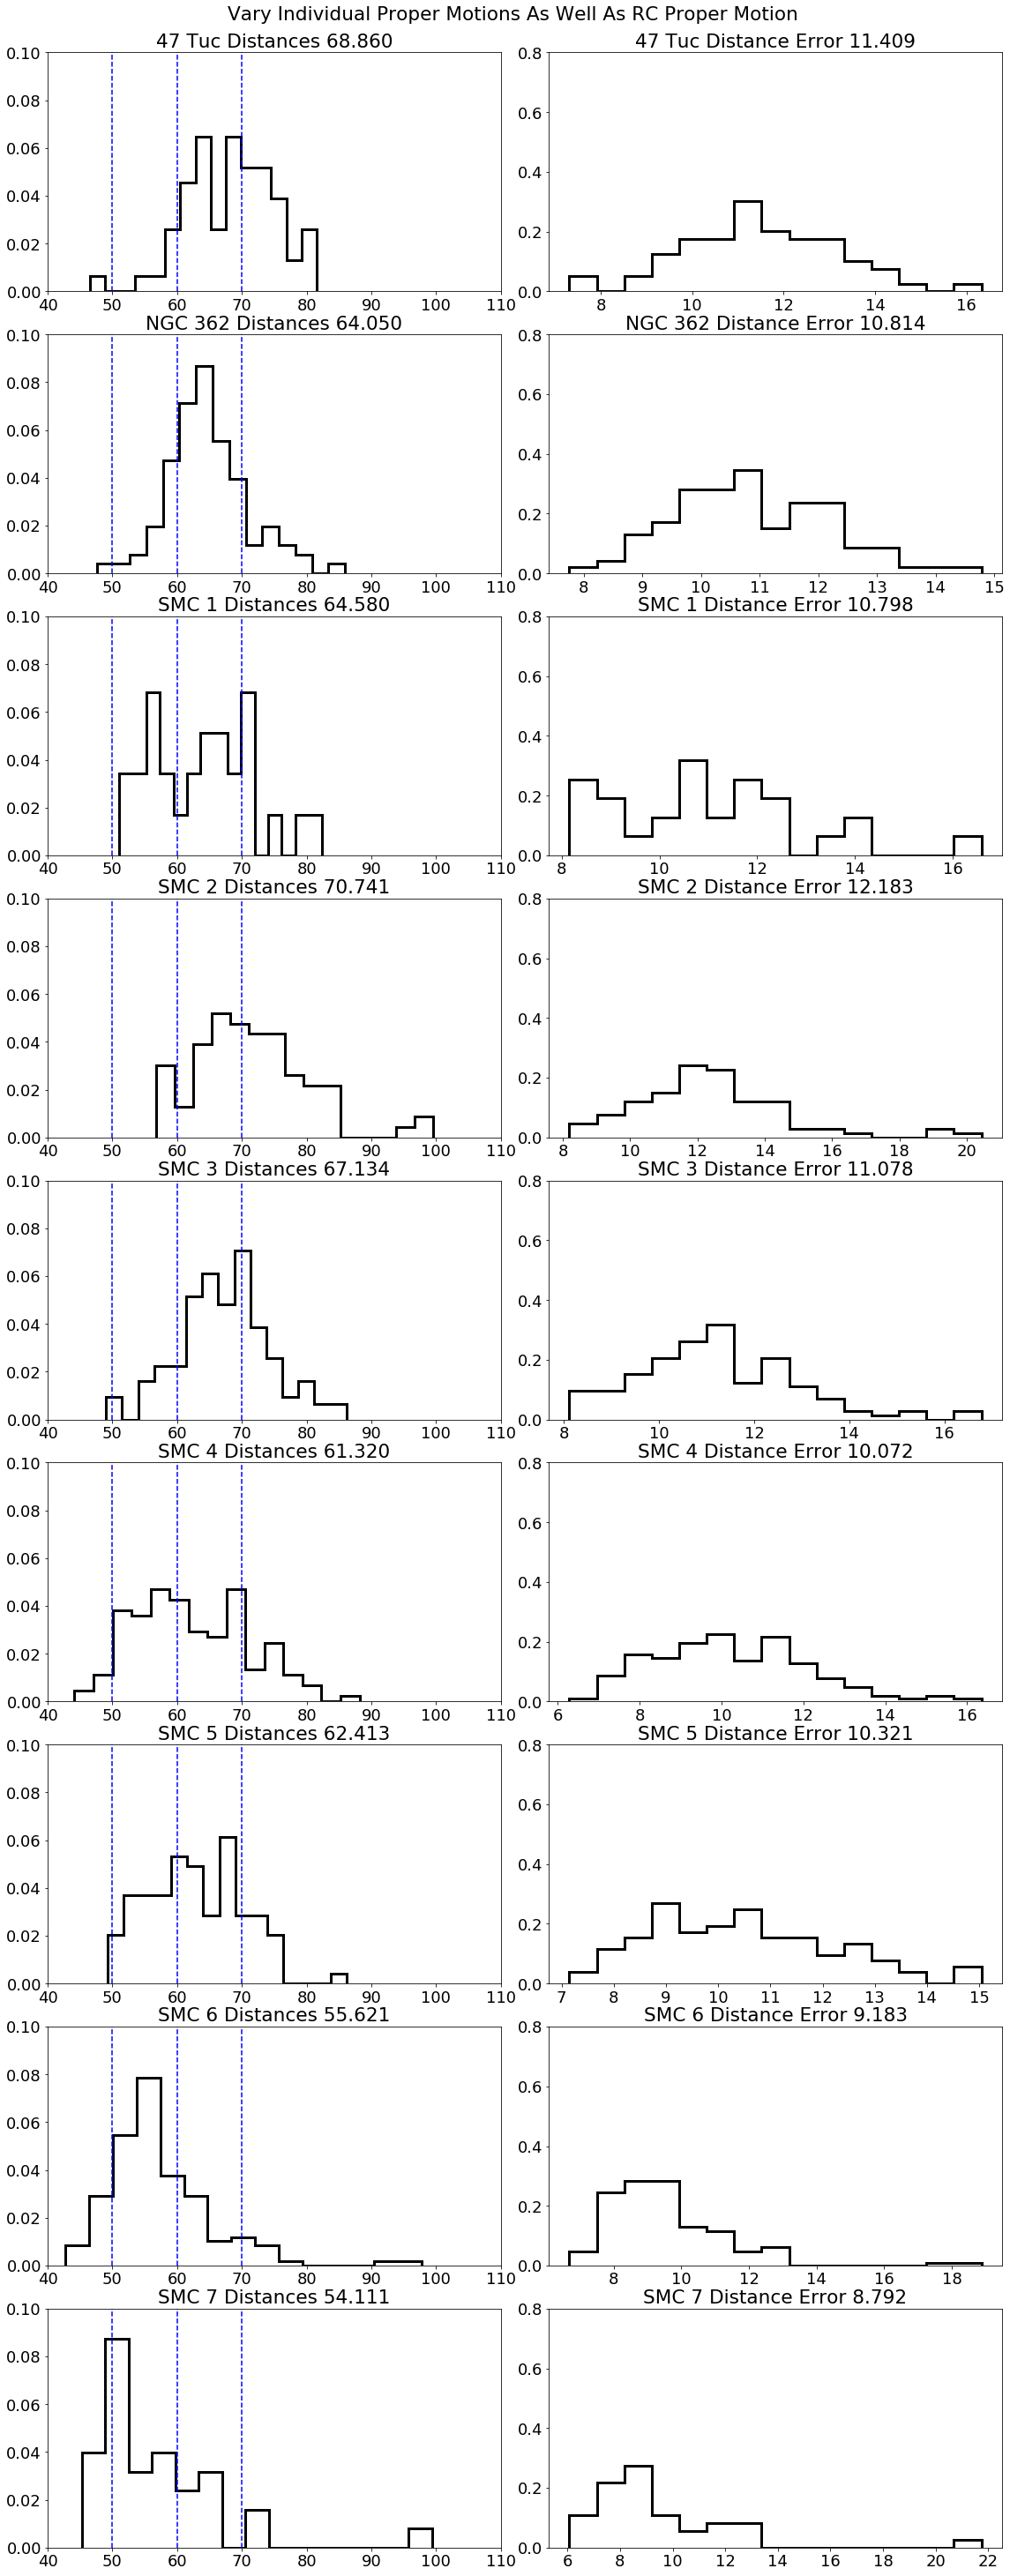

In [25]:
distance_pm_rc_list = [distance_pm_rc[tuc47_ind],distance_pm_rc[n362_ind],distance_pm_rc[smc1_ind],distance_pm_rc[smc2_ind],
                 distance_pm_rc[smc3_ind],distance_pm_rc[smc4_ind],distance_pm_rc[smc5_ind],distance_pm_rc[smc6_ind],
                 distance_pm_rc[smc7_ind]]
distance_pm_rc_err_list = [distance_pm_rc_err[tuc47_ind],distance_pm_rc_err[n362_ind],distance_pm_rc_err[smc1_ind],
                     distance_pm_rc_err[smc2_ind],distance_pm_rc_err[smc3_ind],distance_pm_rc_err[smc4_ind],
                     distance_pm_rc_err[smc5_ind],distance_pm_rc_err[smc6_ind],distance_pm_rc_err[smc7_ind]]
# distance_label = ['47 Tuc','NGC 362','SMC 1','SMC 2','SMC 3','SMC 4','SMC 5','SMC 6','SMC 7']

fig,ax = plt.subplots(9,2,figsize=[16,40])

for i in range(len(ax)):
    ax[i,0].hist(distance_pm_rc_list[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    ax[i,1].hist(distance_pm_rc_err_list[i],density=True,bins=15,histtype='step',lw=3.0,color='k')
    
    ax[i,0].set_ylim(top=0.1)
    ax[i,1].set_ylim(top=0.8)
    
    ax[i,0].set_xlim(40,110)
    
    ax[i,0].set_title(r'{} Distances {:.3f}'.format(distance_label[i],np.median(distance_pm_rc_list[i])))
    ax[i,1].set_title(r'{} Distance Error {:.3f}'.format(distance_label[i],np.median(distance_pm_rc_err_list[i])))
    
    ax[i,0].axvline(50,ls='--',c='b')
    ax[i,0].axvline(60,ls='--',c='b')
    ax[i,0].axvline(70,ls='--',c='b')

plt.suptitle(r'Vary Individual Proper Motions As Well As RC Proper Motion',y=1.01)
plt.tight_layout(pad=0.1)

plt.show()

In [26]:
# plt.plot(np.sqrt(range(100000)),np.floor(np.log10(np.sqrt(range(10**617))))+1)

In [27]:
x=np.array([1,2,3])
np.power(x,3)

array([ 1,  8, 27])